In [62]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle
import kipoiseq
from itertools import combinations
import scipy
import os
import gene as bgene

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
res_paths = glob.glob('../results/gencode_tss_predictions/borzoi/*pickle')

In [40]:
target_df = pd.read_csv('../data/borzoi_targets_human.txt', sep='\t')
cage_tracks = [[i,t.split(':')[-1].strip()] for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() in ['K562 ENCODE, biol_',
                                                               'GM12878 ENCODE, biol_',
                                                               'PC-3'])]

rna_tracks = [[i,t.split(':')[-1].strip()] for i,t in enumerate(target_df['description']) if
              ('RNA' in t) and (t.split(':')[-1].strip() in ['K562',
                                                             'GM12878',
                                                             'PC-3'])]

In [51]:

target_df_path = '../data/borzoi_targets_human.txt'
rna_track_labels = ['K562', 'GM12878', 'PC-3']

rna_track_groups = utils.map_indeces_to_labels_borzoi(rna_track_labels, 'RNA', target_df_path)
cage_track_labels = ['K562 ENCODE, biol_', 'GM12878 ENCODE, biol_', 'PC-3']
cage_track_groups = utils.map_indeces_to_labels_borzoi(cage_track_labels, 'CAGE', target_df_path)

In [158]:
res_path = res_paths[10]
res = utils.read_pickle(res_path)
rna = res['rna'][0]
cage = res['cage'][0]
    
    

In [159]:
res_path

'../results/gencode_tss_predictions/borzoi/PTK7_chr6_43076306_+.pickle'

In [164]:
rna[:, rna_track_groups['PC-3']].sum(axis=0)

array([681.5  ,   1.428, 623.5  ,   2.39 ], dtype=float16)

In [54]:
# target_df = pd.read_csv('../data/borzoi_targets_human.txt', sep='\t')
# cage_tracks = [i for i, t in enumerate(target_df['description']) if
#                ('CAGE' in t) and (t.split(':')[-1].strip() in ['K562 ENCODE, biol_',
#                                                                'GM12878 ENCODE, biol_',
#                                                                'PC-3'])]

# rna_tracks = [i for i, t in enumerate(target_df['description']) if
#               ('RNA' in t) and (t.split(':')[-1].strip() in ['K562',
#                                                              'GM12878',
#                                                              'PC-3'])]
# target_df.iloc[cage_tracks+rna_tracks].to_csv('../data/borzoi_cage_rna_tracks.csv')
model = custom_model.Borzoi('../data/borzoi/*/*', cage_tracks, rna_tracks, aggregate=True)

Adding models:
['../data/borzoi/f0/model0_best.h5', '../data/borzoi/f1/model0_best.h5', '../data/borzoi/f2/model0_best.h5', '../data/borzoi/f3/model0_best.h5']
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-11-16 09:36:38.948340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 09:36:39.958672: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 69493 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:47:00.0, compute capability: 8.0


In [63]:
transcriptome = bgene.Transcriptome('../data/gencode.v44.basic.annotation.gtf')
fasta_path = f'../data//GRCh38.primary_assembly.genome.fa'


In [74]:
seq_parser = utils.SequenceParser(fasta_path)

In [122]:
tss_df = pd.read_csv('../results/tss_positions.csv')

In [171]:
chrom, center_pos = res_path.split('/')[-1].split('_')[1:3]
center_pos = int(center_pos)

In [172]:
tss_df[tss_df['Start']==center_pos]['gene_name']

17174    PTK7
Name: gene_name, dtype: object

In [173]:
res_path

'../results/gencode_tss_predictions/borzoi/PTK7_chr6_43076306_+.pickle'

In [174]:
row = tss_df[tss_df['Start'] == center_pos].iloc[0]

In [175]:
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if row['gene_id'] in gene_key]

In [176]:
gene = transcriptome.genes[gene_keys[0]]

In [177]:
start = center_pos - model.seq_length // 2
end = center_pos + model.seq_length // 2
seq_out_start = start + model.model_strides * model.target_crops
seq_out_len = model.model_strides * model.target_lengths
gene_slice = gene.output_slice(seq_out_start, seq_out_len, model.model_strides, False)

In [178]:
sequence_one_hot = seq_parser.extract_seq_centered(chrom, center_pos, gene.strand, model.seq_length)[np.newaxis]

In [179]:
preds = []
for j, m in enumerate(model.models):
    preds.append(m(sequence_one_hot)[:, None, ...].astype("float16"))
preds = np.concatenate(preds, axis=1)

In [180]:
mean_preds = preds[0].mean(axis=0)[:, 6802]
max_pred = mean_preds.max()

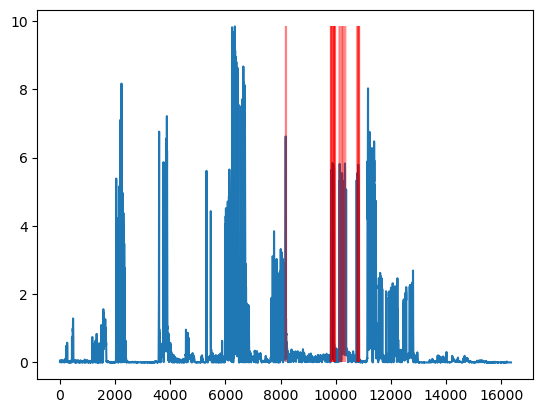

In [183]:
plt.plot(mean_preds)
for g in gene_slice:
    plt.vlines(g, 0, max_pred, color='r', alpha=0.05)

In [153]:
rna_tracks = [i for i, t in enumerate(target_df['description']) if
              ('RNA' in t) and (t.split(':')[-1].strip() =='PC-3'
                                                             )]

rna_tracks

[6802, 6803, 7086, 7087]

In [149]:
rna_track_groups

{'GM12878': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  20,
  21,
  24,
  26,
  29,
  30,
  31,
  32,
  43,
  44,
  45,
  48],
 'K562': [10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  22,
  23,
  25,
  27,
  28,
  35,
  36,
  37,
  38,
  41,
  42,
  46,
  47],
 'PC-3': [33, 34, 39, 40]}